In [11]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments,Trainer, AutoModelForSequenceClassification
import torch
import pandas as pd
import evaluate
from collections import Counter
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig
from transformers import pipeline
import numpy as np
import sys
from IPython.display import Image, display

sys.path.insert(1, '../')
from utils.helper import Helper


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
dataset_name = 'knkarthick/dialogsum'
dataset = load_dataset(dataset_name)
path_to_data = '../data/'
split = 'test'
print(dataset[split][0]['dialogue'])
print("Summary " , dataset['train'][0]['summary'])


#Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messaging in this office. It wastes too much time! Now, please continue with the memo. Wh

In [13]:
model_name = 'google/flan-t5-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name,use_fast=True)

# Zero Shot Inference 

In [7]:
example_indicies = [0,1]
for i,index in enumerate(example_indicies):
    dialoge = dataset[split][index]['dialogue']
    summary = dataset[split][index]['summary']
    
    prompt = f""" 
Dialogue: 
{dialoge} 
What was going on? 
"""
    inputs  = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(model.generate(inputs['input_ids'],max_new_tokens=50)[0],skip_special_tokens=True)
    print("\n Dialoge: \n" , prompt)
    print("\n Summary: \n" , summary)
    print("\n Output: \n"  , output)
    print("-----------------------------------------------")


 Dialoge: 
  
Dialogue: 
#Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messaging in this office. It wastes too much time! Now, please 

# One Shot Learning

In [8]:
example_indicies = [0,1]
for i,index in enumerate(example_indicies):
    dialoge = dataset[split][index]['dialogue']
    summary = dataset[split][index]['summary']
    
    prompt = f""" 
Dialogue: 
{dialoge} 
What was going on? 
{summary}
"""
    prompt = f""" 
Dialogue: 
{dialoge} 
What was going on? 
"""
    inputs  = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(model.generate(inputs['input_ids'],max_new_tokens=50)[0],skip_special_tokens=True)
    print("\n Dialoge: \n" , prompt)
    print("\n Output: \n"  , output)
    print("-----------------------------------------------")


 Dialoge: 
  
Dialogue: 
#Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messaging in this office. It wastes too much time! Now, please 

# Few shot learning

In [9]:
example_indicies = [323,9]
prompt = ''
for i,index in enumerate(example_indicies):
    dialoge = dataset[split][index]['dialogue']
    summary = dataset[split][index]['summary']
    
    prompt += f""" 
Dialogue: 
{dialoge} 
What was going on? 
{summary}
"""
    
index = 1
dialoge = dataset[split][index]['dialogue']
summary = dataset[split][index]['summary']

prompt += f""" 
Dialogue: 
{dialoge} 
What was going on? 
"""

inputs  = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(model.generate(inputs['input_ids'],max_new_tokens=50)[0],skip_special_tokens=True,do_sample=True, tempreture=0.5)
print("\n Dialoge: \n" , prompt)
print("\n Output: \n"  , output)
print("-----------------------------------------------")

Token indices sequence length is longer than the specified maximum sequence length for this model (785 > 512). Running this sequence through the model will result in indexing errors



 Dialoge: 
  
Dialogue: 
#Person1#: Mr. Wilson. We are very regretful about the mistakes in goods. I am very sorry and we will be responsible for the mistake.
#Person2#: We have no choice but to hold you responsible for the loss we sustained.
#Person1#: The first problem is supposed to be solved after the investigation. About the second problem, I admit it's our fault, so we will exchange all merchandise that falls short of our sample.
#Person2#: Well. I hope there won't be such things no more.
#Person1#: I can assure you that such a thing today will never happen again in future delivery. We have made the plan to improve the package of our exported goods. 
What was going on? 
#Person1# apologizes for the loss caused by them to Mr. Wilson and assures that it will never happen again.
 
Dialogue: 
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, ma

# Fully Instruction Fine Tuning

In [14]:
helper = Helper(tokenizer)
tokenized_dataset = dataset.map(helper.tokenizer_function, batched=True)
tokenized_datasets = tokenized_dataset.remove_columns(['id','topic','dialogue','summary'])
tokenized_datasets = tokenized_datasets.filter(lambda example, index : index % 2 == 0, with_indices = True)


Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [15]:
model_o = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base')

training_args = TrainingArguments(output_dir = path_to_data+'summary_data/',
                                 learning_rate=1e-5, 
                                 num_train_epochs=1, 
                                 weight_decay=0.01,
                                 logging_steps=1,
                                 max_steps=1,
                                 auto_find_batch_size=True)

trainer = Trainer(model = model_o, 
                 args = training_args, 
                 train_dataset= tokenized_datasets['test'])

trainer.train()
trainer.save_model('../data/Flan_T5_Full_Fine_Tuned' )


max_steps is given, it will override any value given in num_train_epochs
/Users/raminanushiravani/miniconda3/envs/ramin/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 750
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1
  Number of trainable parameters = 247577856


Step,Training Loss
1,51.655200




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ../data/Flan_T5_Full_Fine_Tuned
Configuration saved in ../data/Flan_T5_Full_Fine_Tuned/config.json
Configuration saved in ../data/Flan_T5_Full_Fine_Tuned/generation_config.json
Model weights saved in ../data/Flan_T5_Full_Fine_Tuned/pytorch_model.bin


# Evaluation 

In [16]:
model_f = AutoModelForSeq2SeqLM.from_pretrained(path_to_data + 'Flan_T5_Full_Fine_Tuned')
model_o = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base')

tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base',use_fast=True)

loading configuration file ../data/Flan_T5_Full_Fine_Tuned/config.json
Model config T5Config {
  "_name_or_path": "../data/Flan_T5_Full_Fine_Tuned",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },


In [17]:
print("original" , sum([p.numel()/1e6 for p in model_o.parameters() if p.requires_grad]) , 'M trainable parameters')


original 247.57785599999906 M trainable parameters


In [20]:
orgs = []
fids = []
gros = []
for i in range(5,15):
    prompt,gr_ = helper.create_prompt([1,2,3], i)
    org_ , fid_ =  helper.gen_output(prompt, model_o, model_f)
    orgs.append(org_)
    fids.append(fid_)
    gros.append(gr_)

zipped_summaries = list(zip(gros,orgs,fids))
df = pd.DataFrame(zipped_summaries,columns=['G','O','F'])


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

/Users/raminanushiravani/miniconda3/envs/ramin/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id":

In [21]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
             predictions=orgs,
             references=gros,
             use_aggregator=True,
             use_stemmer=True)

fined_model_results = rouge.compute(
             predictions=fids,
             references=gros,
             use_aggregator=True,
             use_stemmer=True)

print("Original" , original_model_results)
print("Fined" , fined_model_results)

Original {'rouge1': 0.3241912687702162, 'rouge2': 0.11072943227634303, 'rougeL': 0.3005257374204743, 'rougeLsum': 0.3000090396932502}
Fined {'rouge1': 0.3278627123363965, 'rouge2': 0.11072943227634303, 'rougeL': 0.30404587323008375, 'rougeLsum': 0.3031556562346036}


# Parameter Efficient Fine-Tuning LoRA

Low rank adaptation 

In [23]:
tokenized_dataset = dataset.map(helper.tokenizer_function, batched=True)
tokenized_datasets = tokenized_dataset.remove_columns(['id','topic','dialogue','summary'])
tokenized_datasets = tokenized_datasets.filter(lambda example, index : index % 2 == 0, with_indices = True)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

In [24]:
lora_config = LoraConfig(r = 32, 
                        lora_alpha = 32, 
                        target_modules=['q','v'],
                        lora_dropout = 0.05,
                        bias = "none",
                        task_type=TaskType.SEQ_2_SEQ_LM)

peft_model = get_peft_model(model_o, lora_config)


In [25]:
print("peft" ,sum([p.numel()/1e6 for p in peft_model.parameters()]) , 'M parameters')

print("peft" ,sum([p.numel()/1e6 for p in peft_model.parameters() if p.requires_grad]) , 'M trainable parameters')


peft 251.11679999999868 M parameters
peft 3.5389440000000074 M trainable parameters


In [26]:
peft_training_args = TrainingArguments(output_dir = path_to_data+'summary_data/',
                                 learning_rate=1e-3, 
                                 num_train_epochs=1, 
                                 auto_find_batch_size=True,
                                 weight_decay=0.01,
                                 logging_steps=1,
                                 max_steps=2)

trainer = Trainer(model = peft_model, 
                 args = peft_training_args, 
                 train_dataset= tokenized_datasets['train'],
                 eval_dataset = tokenized_datasets['test'])

trainer.train()
trainer.save_model('../data/Flan_T5_Lora_Fine_Tuned' )

trainer.model.save_pretrained('../data/Flan_T5_Lora_Torch')



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs
/Users/raminanushiravani/miniconda3/envs/ramin/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6230
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2
  Number of trainable parameters = 353894

Step,Training Loss
1,49.967500
2,48.723700




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ../data/Flan_T5_Lora_Fine_Tuned
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


### inference Merge Peft with base

In [27]:
model_o = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base')

tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base',use_fast=True)

# Merging 
peft_model_path = '../data/Flan_T5_Lora_Torch'
peft_model = PeftModel.from_pretrained(model_o,peft_model_path, 
                                       torch_dype = torch.bfloat16,
                                       is_trainable = False)


loading configuration file config.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json
Model config T5Config {
  "_name_or_path": "google/flan-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      

### Evaluation LoRA

In [28]:
model_o = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base')


orgs = []
pfids = []
gros = []
for i in range(5,15):
    prompt,gr_ = helper.create_prompt([1,2,3], i)
    org_ , fid_ =  helper.gen_output(prompt, model_o, peft_model)
    orgs.append(org_)
    pfids.append(fid_)
    gros.append(gr_)

zipped_summaries = list(zip(gros,orgs,pfids))
df = pd.DataFrame(zipped_summaries,columns=['G','O','PEF'])


loading configuration file config.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json
Model config T5Config {
  "_name_or_path": "google/flan-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      

In [29]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
             predictions=orgs,
             references=gros,
             use_aggregator=True,
             use_stemmer=True)

fined_model_results = rouge.compute(
             predictions=pfids,
             references=gros,
             use_aggregator=True,
             use_stemmer=True)

print("Original" , original_model_results)
print("PEFT" , fined_model_results)

Original {'rouge1': 0.3241912687702162, 'rouge2': 0.11072943227634303, 'rougeL': 0.3005257374204743, 'rougeLsum': 0.3000090396932502}
PEFT {'rouge1': 0.3371450742240215, 'rouge2': 0.15053678954419297, 'rougeL': 0.31205136773557823, 'rougeLsum': 0.31111332819227555}


# Fine Tune with RLHF

In [38]:
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

In [31]:
dataset_name = 'knkarthick/dialogsum'
model_name = 'google/flan-t5-base'
dataset = helper.build_dataset(model_name,dataset_name,minLen=200,maxLen=1000)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

loading file spiece.model from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/spiece.model
loading file tokenizer.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/special_tokens_map.json
loading file tokenizer_config.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/tokenizer_config.json


Map:   0%|          | 0/10022 [00:00<?, ? examples/s]

In [32]:

model_o = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base')

lora_config = LoraConfig(r = 32, 
                        lora_alpha = 32, 
                        target_modules=['q','v'],
                        lora_dropout = 0.05,
                        bias = "none",
                        task_type=TaskType.SEQ_2_SEQ_LM)

peft_model_path = '../data/Flan_T5_Lora_Torch'
peft_model = PeftModel.from_pretrained(model_o,
                                       peft_model_path, 
                                       lora_config = lora_config,
                                       torch_dype = torch.bfloat16,
                                       is_trainable = True)


loading configuration file config.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json
Model config T5Config {
  "_name_or_path": "google/flan-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      

### Proximal Policy Optimization Model 

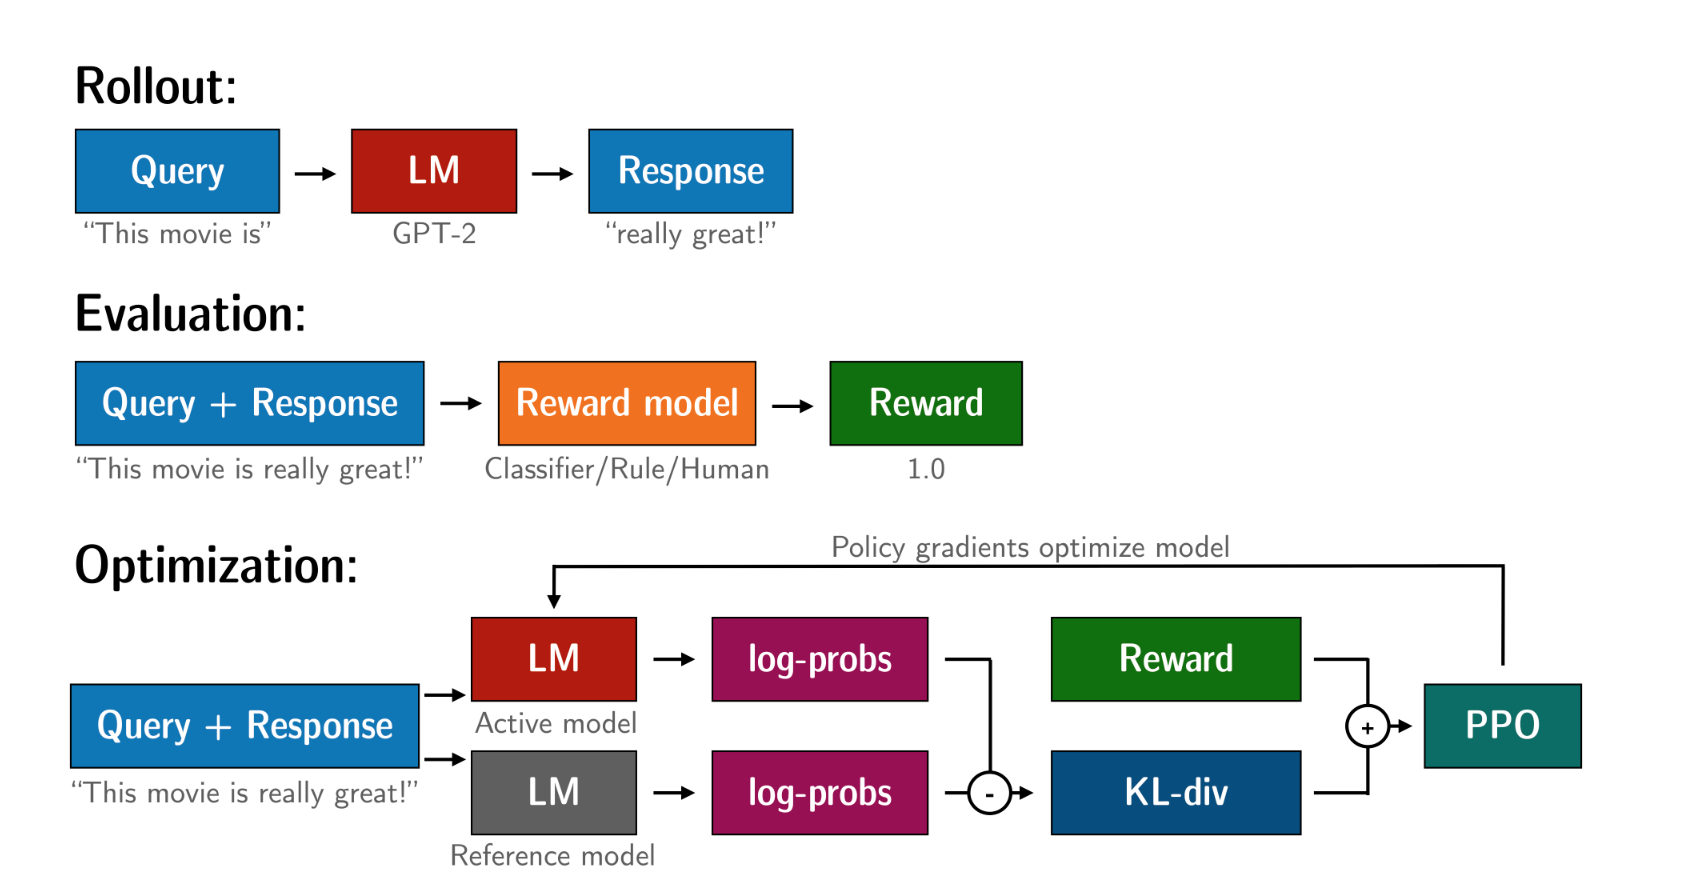

In [33]:
display(Image(filename='../snapshots/ppo.png'))

In [34]:
# ppo model
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,
                                                               torch_dtyoe = torch.bfloat16, 
                                                               is_trainable = True
                                                              ,device_map = 'auto')
# reference model 
ref_model = create_reference_model(ppo_model)

# Later we use KL divergence to compare the output from ppo model to the reference model 

print(ppo_model.v_head)

ValueHead(
  (dropout): Dropout(p=0.1, inplace=False)
  (summary): Linear(in_features=768, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [35]:
toxic_model_name = 'facebook/roberta-hate-speech-dynabench-r4-target'
toxic_tokenizer = AutoTokenizer.from_pretrained(toxic_model_name,device_map = 'auto')
toxic_model = AutoModelForSequenceClassification.from_pretrained(toxic_model_name, device_map = 'auto')


loading file vocab.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--facebook--roberta-hate-speech-dynabench-r4-target/snapshots/391c99ab8b3f65beb77746a2cf6ddf1ddf9817e6/vocab.json
loading file merges.txt from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--facebook--roberta-hate-speech-dynabench-r4-target/snapshots/391c99ab8b3f65beb77746a2cf6ddf1ddf9817e6/merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--facebook--roberta-hate-speech-dynabench-r4-target/snapshots/391c99ab8b3f65beb77746a2cf6ddf1ddf9817e6/special_tokens_map.json
loading file tokenizer_config.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--facebook--roberta-hate-speech-dynabench-r4-target/snapshots/391c99ab8b3f65beb77746a2cf6ddf1ddf9817e6/tokenizer_config.json
loading configuration file conf

In [36]:
device = 0 if torch.cuda.is_available() else 'cpu'
sentiment_pipe = pipeline('sentiment-analysis',model=toxic_model_name, device = device)

reward_logits_kwargs = {"top_k" : None, 
                        "function_to_apply": "none",
                        "batch_size" : 16}

reward_probs_kwargs = {"top_k" : None, 
                        "function_to_apply": "softmax",
                        "batch_size" : 16}

toxic_eval  = evaluate.load("toxicity", toxic_model_name, model_type='measurement',toxic_label= "hate")



loading configuration file config.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--facebook--roberta-hate-speech-dynabench-r4-target/snapshots/391c99ab8b3f65beb77746a2cf6ddf1ddf9817e6/config.json
Model config RobertaConfig {
  "_name_or_path": "facebook/roberta-hate-speech-dynabench-r4-target",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "nothate",
    "1": "hate"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": null,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
 

In [39]:
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map = 'auto')
mean_b_toxic, std_b_toxic = helper.evaluate_toxic(ref_model, toxic_eval=toxic_eval, 
                                           tokenizer=tokenizer, dataset = dataset['test'],
                                           num_samples = 10)
print(f'toxic [mean,std] before detox [{mean_b_toxic},{std_b_toxic}]')



loading file spiece.model from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/spiece.model
loading file tokenizer.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/special_tokens_map.json
loading file tokenizer_config.json from cache at /Users/raminanushiravani/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/tokenizer_config.json
Disabling tokenizer parallelism, we're using DataLoader multithreading already


toxic [mean,std] before detox [0.00672977356324819,0.00872391435122956]


In [40]:
lr = 1.4e-5
max_ppo_epochs = 1
mini_batch_size = 4,
batch_size = 16

config = PPOConfig(
    model_name = model_name,
    learning_rate = lr,
    ppo_epochs =max_ppo_epochs, 
    mini_batch_size=mini_batch_size,
    batch_size=batch_size)

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

ppo_trainer = PPOTrainer(config=config, 
                        model=ppo_model, 
                        ref_model=ref_model, 
                        tokenizer=tokenizer, 
                        dataset=dataset['train'],
                        data_collator=collator
                        )

In [42]:
output_min_len = 100
output_max_len = 400
output_len_sampler = LengthSampler(output_min_len, output_max_len)

generation_kwargs = {
                    "min_length":5,
                    "top_k": 0.0,
                    "top_p":1.0,
                    "do_sample":True}

max_ppo_steps = 10

for step,batch in enumerate(ppo_trainer.dataloader):
    if step >= max_ppo_steps: 
        break
    prompt_tensors = batch['input_ids']
    summary_tensors = []
    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_len_sampler()
        generation_kwargs['max_new_tokens'] = max_new_tokens
        summary = ppo_trainer.generate(prompt_tensor, **generation_kwargs)
        summary_tensors.append(summary.squeeze()[-max_new_tokens:])
    
    batch['response'] = [tokenizer.decode(r.squeeze()) for r in summary_tensors]
    query_response_pair = [q+r for q,r in zip(batch['query'],batch['response'])]
    rewards = sentiment_pipe(query_response_pairs, **reward_kwargs)
    
    reward_tensors = [torch.tensor(reward[not_hate_index]['score']) for reward in rewards]
    stats = ppo_trainer.step(prompt_tensors, summary_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)
    